In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

# NLP Milestone Project - SkimLit Using Tensorflow

In the previous notebook , NLP fundamentals in TensorFlow, we went through some fundamental natural lanuage processing concepts. The main ones being **tokenzation** (turning words into numbers) and **creating embeddings** (creating a numerical representation of words).

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*  

### Model Input

For example, can we train an NLP model which takes the following input (note: the following sample has had all numerical symbols replaced with "@"):

> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ).
Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ).,
Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured.
There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks. The mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively. Further , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group. These differences remained significant at @ weeks. The Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ). Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ).

### Model output

And returns the following output:

```
['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',
 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']
 ```

### Problem in a sentence

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature. 

### Solution in a sentence

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

## What we're going to cover

Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

## Get data

Before we can start building a model, we've got to download the PubMed 200k RCT dataset.

In a phenomenal act of kindness, the authors of the paper have made the data they used for their research availably publically and for free in the form of .txt files [on GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct).

We can copy them to our local directory using `git clone https://github.com/Franck-Dernoncourt/pubmed-rct`.

Install git on system and add environment variable as instructed here:
https://stackoverflow.com/questions/4492979/error-git-is-not-recognized-as-an-internal-or-external-command

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the [README file](https://github.com/Franck-Dernoncourt/pubmed-rct) from the GitHub page, we get the following information:
* PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
* `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
* Since Github file size limit is 100 MiB, we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`. To uncompress `train.7z`, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is `PubMed_20k_RCT_numbers_replaced_with_at_sign`.

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with `@` but we didn't.

Let's check the file contents. 

In [3]:
import os
os.listdir("pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\")

['dev.txt', 'test.txt', 'train.txt']

Looks like we've got three separate text files:
* `train.txt` - training samples.
* `dev.txt` - dev is short for development set, which is another name for validation set (in our case, we'll be using and referring to this file as our validation set).
* `test.txt` - test samples.

To save ourselves typing out the filepath to our target directory each time, let's turn it into a variable.

In [4]:
# Start by using the 20k dataset
data_dir = "pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\"

In [5]:
# Check all File names in Data Directory:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [6]:
filenames

['pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\test.txt',
 'pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt']

## Preprocess data

Okay, now we've downloaded some text data, do you think we're ready to model it?

We've downloaded the data but we haven't even looked at it yet.

We want to *see* lots of values from Data.

Visualize.

To get familiar and understand how we have to prepare our data for our deep learning models, we've got to visualize it.

Because our data is in the form of text files, let's write some code to read each of the lines in a target file.

In [7]:
# Create function to read the lines of a document:

def get_lines(filename):
    """
      Reads filename (a text file) and returns the lines of text as a list.
  
      Args:
          filename: a string containing the target filepath to read.
  
      Returns:
          A list of strings with one string per line from the target filename.
          For example:
          ["this is the first line of filename",
           "this is the second line of filename",
           "..."]
    """
    
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Reading in Lines from Training Data:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Reading the lines from the training text file results in a list of strings containing different abstract samples, the sentences in a sample along with the role the sentence plays in the abstract.

The role of each sentence is prefixed at the start of each line separated by a tab (`\t`) and each sentence finishes with a new line (`\n`).

Different abstracts are separated by abstract ID's (lines beginning with `###`) and newlines (`\n`).

Knowing this, it looks like we've got a couple of steps to do to get our samples ready to pass as training data to our future machine learning model.

Let's write a function to perform the following steps:
* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:  
  * If the line begins with `###` mark it as an abstract ID and the beginning of a new abstract.
    * Keep count of the number of lines in a sample.
  * If the line begins with `\n` mark it as the end of an abstract sample.
    * Keep count of the total lines in a sample.
  * Record the text before the `\t` as the label of the line.
  * Record the text after the `\t` as the text of the line.
* Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
  * `"line_number"` - the position of the line in the abstract (e.g. `3`).
  * `"target"` - the role of the line in the abstract (e.g. `OBJECTIVE`).
  * `"text"` - the text of the line in the abstract.
  * `"total_lines"` - the total lines in an abstract sample (e.g. `14`).
* Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
    
    """Returns a list of dictionaries of abstract line data.

      Takes in filename, reads its contents and sorts through each line,
      extracting things like the target label, the text of the sentence,
      how many sentences are in the current abstract and what sentence number
      the target line is.

      Args:
          filename: a string of the target text file to read and extract line data
          from.

      Returns:
          A list of dictionaries each containing a line from an abstract,
          the lines label, the lines position in the abstract and the total number
          of lines in the abstract where the line is from. For example:

          [{"target": 'CONCLUSION',
            "text": The study couldn't have gone better, turns out people are kinder than you think",
            "line_number": 8,
            "total_lines": 8}]
      """
    
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # Loop through each line in target file
    for line in input_lines:
        
        if line.startswith("###"): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset abstract string
        
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            
        # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["Target"] = target_text_split[0] # get target label
                line_data["Text"] = target_text_split[1].lower() # get target text and lower it
                line_data["Line_Number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["Total_Lines"] = len(abstract_line_split)-1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
            
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
        
    return abstract_samples

In [10]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

In [11]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [12]:
# Checking First Abstract of Training Data:
train_samples[:20]

[{'Target': 'OBJECTIVE',
  'Text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'Line_Number': 0,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'Line_Number': 1,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'Line_Number': 2,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'Line_Number': 3,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'secondary outcome measures included the western ontari

In [13]:
# Turning Data into DataFrame:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df[:15]

,Target,Text,Line_Number,Total_Lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [15]:
# Distribution of Labels in Training Data:
train_df["Target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: Target, dtype: int64

<Axes: ylabel='Frequency'>

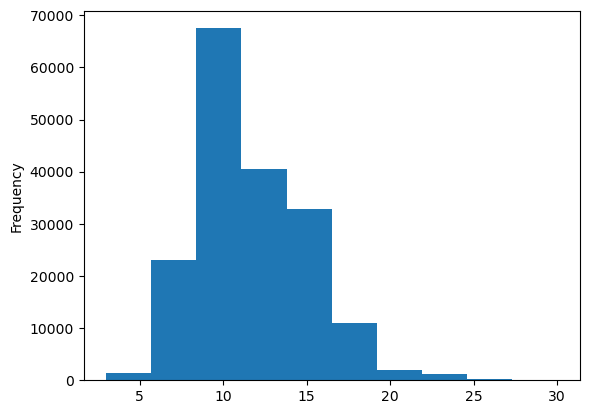

In [16]:
# Distribution of Abstract Lengths:
train_df["Total_Lines"].plot.hist()

### Get lists of sentences

When we build our deep learning model, one of its main inputs will be a list of strings (the lines of an abstract).

We can get these easily from our DataFrames by calling the `tolist()` method on our `"text"` columns.

In [17]:
# Convert abstract text lines into lists 
train_sentences = train_df["Text"].to_list()
val_sentences = val_df["Text"].to_list()
test_sentences = test_df["Text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.

In [19]:
# One hot encoded labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["Target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["Target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["Target"].to_numpy().reshape(-1,1))

In [20]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [22]:
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [23]:
# Extract labels ("target" columns) and encode them into integers:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["Target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["Target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["Target"].to_numpy())

In [24]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
test_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

In [26]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [27]:
# Get class names and number of classes from LabelEncoder instance:

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline 

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [29]:
# Creating a Pipeline for Tf-IDF Vectorization of text and Creating The Model:
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [30]:
# Fitting Model on Training Data:
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# Evaluating The Model Based on Validation Data:
model_0.score(X= val_sentences,
             y= val_labels_encoded)

0.7218323844829869

In [32]:
# Making Predictions Using baseline Model:
baseline_preds = model_0.predict(X= val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

To evaluate our baseline's predictions, we'll import the `calculate_results()` function we created in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb) and added it to our [`helper_functions.py` script](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) to compare them to the ground truth labels.

More specificially the `calculate_results()` function will help us obtain the following:
* Accuracy
* Precision
* Recall
* F1-score

### Download helper functions script

Let's get our `helper_functions.py` script we've been using to store helper functions we've created in previous notebooks.

In [33]:
import wget
url= "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
file= wget.download(url)

In [34]:
from helper_functions import calculate_results

In [35]:
# Calculating Results for Baseline Model:
baseline_results = calculate_results(y_true= val_labels_encoded,
                                    y_pred= baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, LSTM, GRU, TextVectorization, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

In [37]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

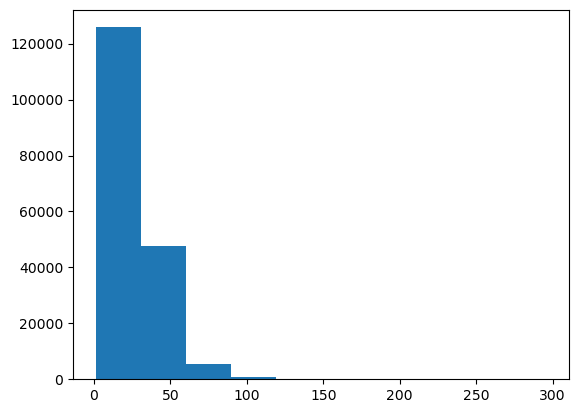

In [38]:
# Distribution of Sentence Lengths in Training Data:
import matplotlib.pyplot as plt
plt.hist(sent_lens)
plt.show()

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [39]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

> 🤔 **Question:** Why 95%?

We could use the max sentence length of the sentences in the training set.

In [40]:
max(sent_lens)

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

> 🔑 **Note:** The steps we've gone through are good practice when working with a text corpus for a NLP problem. You want to know how long your samples are and what the distribution of them is. See section 4 Data Analysis of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) for further examples.

### Create text vectorizer

Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

Section 3.2 of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our `max_tokens` parameter.

And since discovered a sentence length of 55 covers 95% of the training sentences, we'll use that as our `output_sequence_length` parameter.

In [41]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens= 68000

In [42]:
# Creating a Text Vectorizer:
text_vectorizer = TextVectorization(max_tokens= max_tokens, # number of words in vocabulary
                                   output_sequence_length= 55) # desired output length of vectorized sequences

In [43]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [44]:
# Testing Text Vectorize:
import random
random_sentence = random.choice(train_sentences)
print(f"Original Text: {random_sentence}")
print(f"Length of Original Text: {len(random_sentence.split())}")
print(f"Vectorized Text:\n {text_vectorizer([random_sentence])}")

Original Text: each eye from eligible patients was separately randomized to receive super flex or parasol punctal plugs .
Length of Original Text: 17
Vectorized Text:
 [[  122   672    27   518    12    10  2219    29     6   175 15381  8272
     16 25298 18088 18157     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [45]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of Words in Vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most Common 5 Words in Vocabulary:\n {rct_20k_text_vocab[:5]}")
print(f"Least Common 5 Words in Vocabulay:\n {rct_20k_text_vocab[-5:]}")

Number of Words in Vocabulary: 64841
Most Common 5 Words in Vocabulary:
 ['', '[UNK]', 'the', 'and', 'of']
Least Common 5 Words in Vocabulay:
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [46]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

Our `token_vectorization` layer maps the words in our text directly to numbers. However, this doesn't necessarily capture the relationships between those numbers.

To create a richer numerical representation of our text, we can use an **embedding**.

As our model learns (by going through many different examples of abstract sentences and their labels), it'll update its embedding to better represent the relationships between tokens in our corpus.

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [47]:
# Creating Token Embedding Layer:
token_embed = Embedding(input_dim= len(rct_20k_text_vocab), # length of vocabulary
                       output_dim= 128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                       mask_zero= True, # Use masking to handle variable sequence lengths (save space)
                       name= "Token_Embedding")

In [48]:
# Sample Embedding:
print(f"Sentence Before Vectorization:\n {random_sentence}\n")
print(f"Sentence After Vectorization(Before Embedding): \n {text_vectorizer([random_sentence])}")
print(f"Sentence After Embedding:\n {token_embed(text_vectorizer([random_sentence]))}")
print(f"Shape of Embedded Sentence: {token_embed(text_vectorizer([random_sentence])).shape}")

Sentence Before Vectorization:
 each eye from eligible patients was separately randomized to receive super flex or parasol punctal plugs .

Sentence After Vectorization(Before Embedding): 
 [[  122   672    27   518    12    10  2219    29     6   175 15381  8272
     16 25298 18088 18157     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence After Embedding:
 [[[-0.04207971  0.00196785 -0.01591442 ...  0.00929499 -0.04893987
   -0.02966739]
  [-0.01632358 -0.03441064 -0.02243236 ... -0.02117771 -0.00049361
   -0.03029113]
  [-0.02428682 -0.04221374 -0.02788781 ...  0.01163052  0.01267872
   -0.01967617]
  ...
  [ 0.0209576   0.00520676  0.03686816 ... -0.02458925 -0.01922183
    0.03750839]
  [ 0.0209576   0.00520676  0.03686816 ... -0.02458925 -0.01922183
    0.03750839]
  [ 0.0209576   0.00

## Create datasets (as fast as possible)
​
We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.
​
Namely, the `tf.data` API provides methods which enable faster data loading.
​
> 📖 **Resource:** For best practices on data loading in TensorFlow, check out the following:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)
​
The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.
​
Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.
​
To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [49]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [50]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [51]:
# Take the TensorSliceDatasets and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [52]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

We've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the `Layers` component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network. 

We're also going to be following the standard machine learning workflow of:
- Build model
- Train model
- Evaluate model (make predictions and compare to ground truth)

In [53]:
# Creating 1D Convolution Model for Sequence (Text) Data:

inputs = Input(shape=(1,), dtype= tf.string)

x = text_vectorizer(inputs) # vectorize text inputs

x = token_embed(x) # create embedding

x = Conv1D(filters= 64, kernel_size= 5, padding= "same", activation= "relu")(x)

x = GlobalAveragePooling1D()(x) # condense the output of our feature vector

outputs = Dense(num_classes, activation= "softmax")(x)

model_1 = Model(inputs, outputs)

In [54]:
# Compiling The Model:
model_1.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

In [55]:
# Summary of The Model:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 Token_Embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter of the `Embedding` layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

> 🔑 **Note:** It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

In [56]:
# Fitting The Model:

model_1_history = model_1.fit(train_dataset,
                             validation_data= val_dataset,
                             epochs= 3,
                             steps_per_epoch= int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                             validation_steps= int(0.1 * len(val_dataset))) # only validate on 10% of batches

Epoch 1/3

562/562 [==============================] - 22s 23ms/step - loss: 0.9094 - accuracy: 0.6425 - val_loss: 0.6819 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 13s 22ms/step - loss: 0.6590 - accuracy: 0.7539 - val_loss: 0.6287 - val_accuracy: 0.7706
Epoch 3/3
562/562 [==============================] - 13s 22ms/step - loss: 0.6211 - accuracy: 0.7712 - val_loss: 0.5982 - val_accuracy: 0.7856


In [57]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(val_dataset)

945/945 [==============================] - 1s 1ms/step - loss: 0.6013 - accuracy: 0.7838


[0.6013478636741638, 0.7838276028633118]

In [58]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:10]

945/945 [==============================] - 1s 1ms/step


array([[4.18983847e-01, 1.95208937e-01, 9.58205089e-02, 2.60115832e-01,
        2.98708361e-02],
       [4.90679622e-01, 2.50272214e-01, 1.57894138e-02, 2.34725520e-01,
        8.53313413e-03],
       [1.57113820e-01, 7.03221932e-03, 2.24998966e-03, 8.33555579e-01,
        4.83952463e-05],
       [1.13360902e-05, 3.11211072e-04, 9.80907619e-01, 1.15247576e-05,
        1.87583268e-02],
       [1.18245021e-03, 4.19557467e-02, 3.25557142e-01, 9.13842639e-04,
        6.30390882e-01],
       [1.75528415e-02, 2.86054891e-02, 5.98958969e-01, 7.55679049e-03,
        3.47325891e-01],
       [2.83497619e-04, 2.95592216e-03, 2.61368155e-01, 1.28158397e-04,
        7.35264361e-01],
       [2.52646264e-02, 2.63182148e-02, 6.93526864e-01, 1.19486740e-02,
        2.42941648e-01],
       [5.94536695e-14, 1.41707694e-08, 9.35558049e-08, 6.51461849e-14,
        9.99999881e-01],
       [6.61624596e-03, 6.94158733e-01, 3.35337892e-02, 1.11613069e-02,
        2.54529893e-01]], dtype=float32)

In [59]:
# Converting The Model Prediction Probabilities to Labels:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [60]:
# Calculate Model 1 Results:
model_1_results = calculate_results(y_true= val_labels_encoded,
                                   y_pred= model_1_preds)
model_1_results

{'accuracy': 78.38276181649675,
 'precision': 0.779909001499204,
 'recall': 0.7838276181649676,
 'f1': 0.7809835407727527}

## Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2).

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

![TensorFlow Hub Universal Feature Encoder feature extractor model we're building](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-model-tf-hub-USE-to-dense-layer.png)
*The feature extractor model we're building using a pretrained embedding from TensorFlow Hub.*

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 **Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [61]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(handle= "https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2",
                                       trainable= False,
                                       name= "Universal_Sentence_Encoder")

In [62]:
# Test out the embedding on a random sentence
random_sentence = random.choice(train_sentences)
print(f"Random Training Sentence:\n {random_sentence}")
random_sentence_embedded = tf_hub_embedding_layer([random_sentence])
print(f"Sentence After Embedding:\n {random_sentence_embedded[0][:30]}")
print(f"Shape of Embedded Sentence:\n {random_sentence_embedded.shape}")

Random Training Sentence:
 a total of @ participants ( @ in each arm ) will be required to detect a five-point mean difference between the intervention arms adjusting for baseline symptom severity , at @ % power and @ % confidence .
Sentence After Embedding:
 [ 0.02744454 -0.06785654 -0.02949052 -0.00458852  0.00816163 -0.021144
  0.05535561  0.02102121 -0.02221842  0.0654484   0.0805371   0.01969325
  0.04471773  0.00884837  0.00817777 -0.02954979 -0.01214839 -0.02926729
 -0.03002883  0.04077614 -0.04520699  0.05589524 -0.06906616 -0.00245628
 -0.0032238  -0.00669171 -0.00983913  0.03856823  0.01350025  0.03317497]
Shape of Embedded Sentence:
 (1, 512)


### Building and fitting an NLP feature extraction model from TensorFlow Hub

In [63]:
# Creating Feature Extractor Model using Tf Hub Pre-Trained Model:

inputs = Input(shape= [], dtype= tf.string)
x = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = Dense(128, activation= "relu")(x)  # add a fully connected layer on top of the embedding
outputs = Dense(num_classes, activation= "softmax")(x)

model_2 = Model(inputs, outputs)

In [64]:
# Compiling The Model:
model_2.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

In [65]:
# Summary of The Model:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_Sentence_Encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [66]:
# Fitting Training Data on Model 2:
model_2_history = model_2.fit(train_dataset,
                             validation_data= val_dataset,
                             epochs= 3,
                             steps_per_epoch= int(0.1 * len(train_dataset)),
                             validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 4ms/step - loss: 0.9161 - accuracy: 0.6474 - val_loss: 0.7962 - val_accuracy: 0.6855
Epoch 2/3
562/562 [==============================] - 2s 4ms/step - loss: 0.7691 - accuracy: 0.7013 - val_loss: 0.7537 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 2s 4ms/step - loss: 0.7528 - accuracy: 0.7127 - val_loss: 0.7380 - val_accuracy: 0.7144


In [67]:
# Evaluating Model 2:
model_2.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.7408 - accuracy: 0.7125


[0.7407639026641846, 0.7124983668327332]

In [68]:
# Making Predictions with Model 2:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 3s 3ms/step


array([[4.43239450e-01, 3.44401270e-01, 2.30048527e-03, 2.01790720e-01,
        8.26805457e-03],
       [3.73276800e-01, 4.55142915e-01, 4.56964178e-03, 1.62442207e-01,
        4.56846086e-03],
       [2.44474113e-01, 1.57110527e-01, 2.05174666e-02, 5.37507296e-01,
        4.03905287e-02],
       [1.17601808e-02, 4.59672958e-02, 8.31903398e-01, 7.79471034e-03,
        1.02574371e-01],
       [3.44517417e-02, 2.31613427e-01, 2.37592161e-01, 1.54917622e-02,
        4.80850935e-01],
       [1.09146931e-03, 1.98191102e-03, 6.54510796e-01, 1.17402786e-04,
        3.42298448e-01],
       [1.91932963e-03, 3.00535141e-03, 6.43784881e-01, 1.27662520e-03,
        3.50013822e-01],
       [4.52052709e-03, 2.14225985e-02, 5.07183611e-01, 9.14648466e-04,
        4.65958655e-01],
       [6.21567888e-04, 8.58325697e-03, 1.89391002e-02, 1.05759269e-03,
        9.70798433e-01],
       [1.20304026e-01, 7.06370473e-01, 2.31707040e-02, 8.22212696e-02,
        6.79335147e-02]], dtype=float32)

In [69]:
# Converting Prediction Probabilities to Labels:
model_2_preds = tf.argmax(model_2_pred_probs, axis= 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [70]:
# calculating Results of Model 2:
model_2_results = calculate_results(y_true= val_labels_encoded,
                                   y_pred= model_2_preds)
model_2_results

{'accuracy': 71.24983450284655,
 'precision': 0.7127276853372058,
 'recall': 0.7124983450284655,
 'f1': 0.7093087308541123}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

![example of difference between token level and character level embeddings](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png)
*Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.*

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [71]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Testing The Function:
split_chars(random_sentence)

'a   t o t a l   o f   @   p a r t i c i p a n t s   (   @   i n   e a c h   a r m   )   w i l l   b e   r e q u i r e d   t o   d e t e c t   a   f i v e - p o i n t   m e a n   d i f f e r e n c e   b e t w e e n   t h e   i n t e r v e n t i o n   a r m s   a d j u s t i n g   f o r   b a s e l i n e   s y m p t o m   s e v e r i t y   ,   a t   @   %   p o w e r   a n d   @   %   c o n f i d e n c e   .'

In [72]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [73]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [74]:
# What's the average character length in  a sentence?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

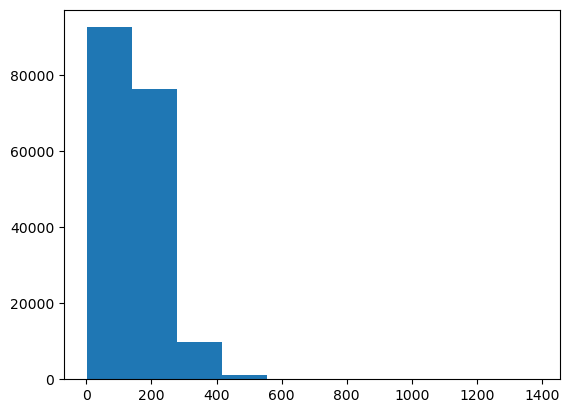

In [75]:
# Check the distribution of our sequences at character-level
plt.hist(char_lens)
plt.show()

In [76]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

We'll set `max_tokens` (the total number of different characters in our sequences) to 28, in other words, 26 letters of the alphabet + space + OOV (out of vocabulary or unknown) tokens.

In [77]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

char_vectorizer = TextVectorization(max_tokens= NUM_CHAR_TOKENS,
                                   output_sequence_length= output_seq_char_len,
                                   standardize= "lower_and_strip_punctuation",
                                   name= "Char_Vectorizer")

In [79]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [80]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of Different Characters in Character Vocabulary: {len(char_vocab)}")
print(f"Most Common 5 Characters: {char_vocab[:5]}")
print(f"Least Common 5 Characters: {char_vocab[-5:]}")

Number of Different Characters in Character Vocabulary: 28
Most Common 5 Characters: ['', '[UNK]', 'e', 't', 'i']
Least Common 5 Characters: ['k', 'x', 'z', 'q', 'j']


In [81]:
# Test out character vectorizer
random_chars = random.choice(train_chars)
print(f"Charified Text:\n {random_chars}")
print(f"Length of Random Characters: {len(random_chars)}\n")

vectorized_chars = char_vectorizer([random_chars])
print(f"Vectorized Chars:\n {vectorized_chars}")
print(f"Length of Vectorized Characters: {len(vectorized_chars[0])}")

Charified Text:
 t h e   p r i m a r y   o u t c o m e   w a s   s u r g i c a l   t r e a t m e n t   o f   r e c u r r e n c e   w i t h   c u r a t i v e   i n t e n t   ;   s e c o n d a r y   o u t c o m e s   w e r e   m o r t a l i t y   (   t o t a l   a n d   c o l o r e c t a l   c a n c e r   )   ,   t i m e   t o   d e t e c t i o n   o f   r e c u r r e n c e   ,   a n d   s u r v i v a l   a f t e r   t r e a t m e n t   o f   r e c u r r e n c e   w i t h   c u r a t i v e   i n t e n t   .
Length of Random Characters: 493

Vectorized Chars:
 [[ 3 13  2 14  8  4 15  5  8 19  7 16  3 11  7 15  2 20  5  9  9 16  8 18
   4 11  5 12  3  8  2  5  3 15  2  6  3  7 17  8  2 11 16  8  8  2  6 11
   2 20  4  3 13 11 16  8  5  3  4 21  2  4  6  3  2  6  3  9  2 11  7  6
  10  5  8 19  7 16  3 11  7 15  2  9 20  2  8  2 15  7  8  3  5 12  4  3
  19  3  7  3  5 12  5  6 10 11  7 12  7  8  2 11  3  5 12 11  5  6 11  2
   8  3  4 15  2  3  7 10  2  3  2 11  3  4  7  6  7 17  8  2 11 1

### Creating a character-level embedding
We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.

Just like our custom token embedding, we can do so using the [`tensorflow.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) class.

Our character-level embedding layer requires an input dimension and output dimension. 

The input dimension (`input_dim`) will be equal to the number of different characters in our `char_vocab` (28). And since we're following the structure of the model in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), the output dimension of the character embedding (`output_dim`) will be 25.

In [82]:
# Create Embedding Layer for Character Level:

char_embed = Embedding(input_dim= len(char_vocab), # number of different characters
                      output_dim= 25,  # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                      name= "Char_Embed")

In [83]:
# Test out character embedding layer
print(f"Charified Text(Before Vectorization and Embedding):\n {random_chars}\n")

vectorized_chars = char_vectorizer([random_chars])
print(f"Vectorized Chars:\n {vectorized_chars}\n")

embeded_chars = char_embed(vectorized_chars)
print(f"Embedded Chars:\n {embeded_chars}")
print(f"Shape of Embedded Characters: {embeded_chars.shape}")

Charified Text(Before Vectorization and Embedding):
 t h e   p r i m a r y   o u t c o m e   w a s   s u r g i c a l   t r e a t m e n t   o f   r e c u r r e n c e   w i t h   c u r a t i v e   i n t e n t   ;   s e c o n d a r y   o u t c o m e s   w e r e   m o r t a l i t y   (   t o t a l   a n d   c o l o r e c t a l   c a n c e r   )   ,   t i m e   t o   d e t e c t i o n   o f   r e c u r r e n c e   ,   a n d   s u r v i v a l   a f t e r   t r e a t m e n t   o f   r e c u r r e n c e   w i t h   c u r a t i v e   i n t e n t   .

Vectorized Chars:
 [[ 3 13  2 14  8  4 15  5  8 19  7 16  3 11  7 15  2 20  5  9  9 16  8 18
   4 11  5 12  3  8  2  5  3 15  2  6  3  7 17  8  2 11 16  8  8  2  6 11
   2 20  4  3 13 11 16  8  5  3  4 21  2  4  6  3  2  6  3  9  2 11  7  6
  10  5  8 19  7 16  3 11  7 15  2  9 20  2  8  2 15  7  8  3  5 12  4  3
  19  3  7  3  5 12  5  6 10 11  7 12  7  8  2 11  3  5 12 11  5  6 11  2
   8  3  4 15  2  3  7 10  2  3  2 11  3  4  7  6  7 17  8  2 1

### Building a Conv1D model to fit on character embeddings
Now we've got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (`model_1`) except it'll take character-level sequences as input instead of token-level sequences.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)```

In [84]:
# Making Conv1D Model on chars only:

inputs = Input(shape= (1,), dtype= tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = Conv1D(filters=64, kernel_size= 5, padding= "same", activation= "relu")(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation= "softmax")(x)

model_3 = Model(inputs, outputs, name= "Model_3_Conv1D_Char_Embeddings")

In [85]:
# Compile The Model:
model_3.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

In [86]:
# Summary of The Model:
model_3.summary()

Model: "Model_3_Conv1D_Char_Embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 Char_Vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 Char_Embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [87]:
# Creating Character Level Datasets:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
train_char_dataset, test_char_dataset, val_char_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [89]:
# Fitting The MOdel:
model_3_history = model_3.fit(train_char_dataset,
                             validation_data= val_char_dataset,
                             epochs= 3,
                             steps_per_epoch= int(0.1 * len(train_char_dataset)),
                             validation_steps= int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 3s 4ms/step - loss: 1.2680 - accuracy: 0.4833 - val_loss: 1.0357 - val_accuracy: 0.5818
Epoch 2/3
562/562 [==============================] - 2s 3ms/step - loss: 0.9857 - accuracy: 0.6079 - val_loss: 0.9111 - val_accuracy: 0.6396
Epoch 3/3
562/562 [==============================] - 2s 4ms/step - loss: 0.9021 - accuracy: 0.6460 - val_loss: 0.8475 - val_accuracy: 0.6742


In [90]:
# Evaluating The Model on Whole Validation Data:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 2s 2ms/step - loss: 0.8658 - accuracy: 0.6648


[0.8657508492469788, 0.6647689938545227]

In [91]:
# Making Predictions Uing The Model:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.19097094, 0.51903343, 0.06404234, 0.20888145, 0.01707182],
       [0.19823346, 0.3092957 , 0.00866179, 0.477063  , 0.00674607],
       [0.17378676, 0.10953572, 0.094519  , 0.59532964, 0.02682888],
       ...,
       [0.02640783, 0.06086794, 0.10884982, 0.0518012 , 0.7520733 ],
       [0.02936592, 0.12424065, 0.31092176, 0.06301646, 0.47245517],
       [0.32849112, 0.3480803 , 0.16405103, 0.15529636, 0.00408118]],
      dtype=float32)

In [92]:
# Converting Model Probabilities into Class Labels:
model_3_preds = tf.argmax(model_3_pred_probs, axis= 1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 1], dtype=int64)>

In [93]:
# Calculating Model 3 Results:
model_3_results = calculate_results(y_true= val_labels_encoded,
                                   y_pred= model_3_preds)

model_3_results

{'accuracy': 66.47689659737853,
 'precision': 0.6585696475744108,
 'recall': 0.6647689659737852,
 'f1': 0.655398130139813}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)


In moving closer to build a model similar to the one in Figure 1 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:
1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [94]:
# 1. Setup Token Inputs and Model:

token_inputs = Input(shape= [], dtype= tf.string, name= "Token_Input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = Dense(128, activation= "relu")(token_embeddings)
token_model= Model(token_inputs, token_output)

# 2. Setup Character Level Inputs and Model:

char_inputs = Input(shape= (1,), dtype= tf.string, name= "Char_Input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = Model(char_inputs, char_bi_lstm)

# 3. Concatenate Token and Character Inputs (Create Hybrid Embedding)

token_char_concat = Concatenate(name= "Toke_Char_Hybrid")([token_model.output,
                                                          char_model.output])

# 4. Create Output Layers:
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(128, activation= "relu")(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes, activation= "softmax")(final_dropout)

# 5.Construct MOdel with Character andf Token Inputs:

model_4 = Model(inputs= [token_model.input, char_model.input],
               outputs= output_layer,
               name= "Model_4_Toke_Char_Embeddings")

In [95]:
# Summary of The Model:
model_4.summary()

Model: "Model_4_Toke_Char_Embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Token_Input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 Char_Vectorizer (TextVecto  (None, 290)                  0         ['Char_Input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_Sentence_Encoder  (None, 512)                  2567978   ['T

In [99]:
# Compiling The Model:

model_4.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(),
               metrics= ["accuracy"])

To keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. However, the difference with this model is that it requires two inputs, token-level sequences and character-level sequences.

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:
* `((token_data, char_data), (label))`

Let's see it in action.

### Combining token and character data into a `tf.data` dataset

In [100]:
# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels


# Prefetch and Batch Train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [101]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [102]:
# Fitting The Model:
model_4_history = model_4.fit(train_char_token_dataset,
                             validation_data= val_char_token_dataset,
                             epochs= 3,
                             steps_per_epoch= int(0.1 * len(train_char_token_dataset)),
                             validation_steps= int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 22s 30ms/step - loss: 0.9800 - accuracy: 0.6090 - val_loss: 0.7885 - val_accuracy: 0.6928
Epoch 2/3
562/562 [==============================] - 16s 28ms/step - loss: 0.8088 - accuracy: 0.6886 - val_loss: 0.7222 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 16s 28ms/step - loss: 0.7742 - accuracy: 0.7042 - val_loss: 0.7026 - val_accuracy: 0.7330


In [103]:
# Evaluating The Model on Whole validation DataSet:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 8s 8ms/step - loss: 0.7084 - accuracy: 0.7309


[0.7083781957626343, 0.7308685183525085]

In [104]:
# Mking Predictions:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 9s 8ms/step


array([[3.4731188e-01, 4.3466651e-01, 4.3690368e-03, 2.0718896e-01,
        6.4636157e-03],
       [3.2640889e-01, 4.2037916e-01, 2.4601147e-03, 2.4934858e-01,
        1.4032730e-03],
       [2.8457245e-01, 7.0115507e-02, 2.5802817e-02, 6.0653102e-01,
        1.2978158e-02],
       ...,
       [4.8096222e-04, 5.1638531e-03, 4.7216870e-02, 1.2803129e-04,
        9.4701034e-01],
       [7.6024560e-03, 3.2909602e-02, 2.6976088e-01, 3.9004062e-03,
        6.8582660e-01],
       [2.6520064e-01, 2.9452342e-01, 3.2998613e-01, 4.0956907e-02,
        6.9332913e-02]], dtype=float32)

In [105]:
# Converting Model Probabilities to Class Labels:
model_4_preds = tf.argmax(model_4_pred_probs, axis= 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [107]:
# Calculating Results for Model 4:
model_4_results = calculate_results(y_true= val_labels_encoded,
                                   y_pred= model_4_preds)
model_4_results

{'accuracy': 73.08685290613002,
 'precision': 0.7326533834700563,
 'recall': 0.7308685290613002,
 'f1': 0.7289010562212377}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings 


There's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

Or

* `BACKGROUND` ...
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...
* `CONCLUSIONS` ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,
* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* `Sentence 4 of 10` ...
* ...


You might've noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [113]:
train_df.head()

,Target,Text,Line_Number,Total_Lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `"line_number"` and `"total_lines"` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. In other words, the positional embedding is where the sentence appears in an abstract.

We can use these features because they will be available at test time. 

![example of engineering features into our dataset to help our model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-engineered-features-at-test-time.png)
*Since abstracts typically have a sequential order about them (for example, background, objective, methods, results, conclusion), it makes sense to add the line number of where a particular sentence occurs to our model. The beautiful thing is, these features will be available at test time (we can just count the number of sentences in an abstract and the number of each one).*

Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.

Exercise: Another way of creating our positional embedding feature would be to combine the `"line_number"` and `"total_lines"` columns into one, for example a `"line_position"` column may contain values like `1_of_11`, `2_of_11`, etc. Where `1_of_11` would be the first line in an abstract 11 sentences long. After going through the following steps, you might want to revisit this positional embedding stage and see how a combined column of `"line_position"` goes against two separate columns.

### Create positional embeddings

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

To do this, we can use the [`tf.one_hot`](https://www.tensorflow.org/api_docs/python/tf/one_hot) utility.

`tf.one_hot` returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the `depth` parameter determines the dimension of the returned tensor.

To figure out what we should set the `depth` parameter to, let's investigate the distribution of the `"line_number"` column.

Note: When it comes to one-hot-encoding our features, Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class is another viable option here.

In [114]:
# Checking How Many Different Line Numbers are there:
train_df["Line_Number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: Line_Number, dtype: int64

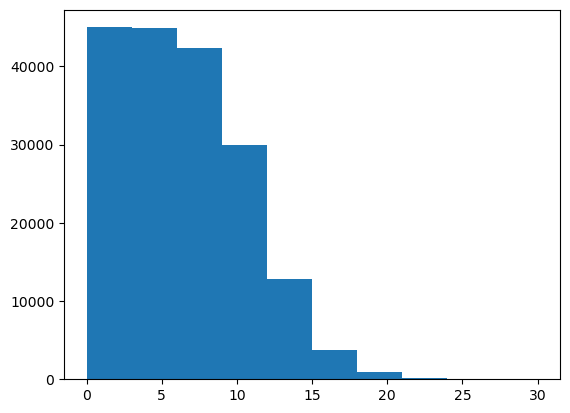

In [115]:
# Distribution of Line Numbers:
plt.hist(train_df["Line_Number"])
plt.show()

Looking at the distribution of the `"line_number"` column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the `depth` parameter of `tf.one_hot` to 15.

In [118]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 

train_line_numbers_one_hot = tf.one_hot(train_df["Line_Number"].to_numpy(), depth= 15)
val_line_numbers_one_hot = tf.one_hot(val_df["Line_Number"].to_numpy(), depth= 15)
test_line_numbers_one_hot = tf.one_hot(test_df["Line_Number"].to_numpy(), depth= 15)

In [119]:
train_line_numbers_one_hot[:15], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [120]:
train_line_numbers_one_hot.shape, val_line_numbers_one_hot.shape, test_line_numbers_one_hot.shape

(TensorShape([180040, 15]), TensorShape([30212, 15]), TensorShape([30135, 15]))

Setting the `depth` parameter of `tf.one_hot` to 15 means any sample with a `"line_number"` value of over 15 gets set to a tensor of all 0's, where as any sample with a `"line_number"` of under 15 gets turned into a tensor of all 0's but with a 1 at the index equal to the `"line_number"` value.

Note: We could create a one-hot tensor which has room for all of the potential values of `"line_number"` (`depth=30`), however, this would end up in a tensor of double the size of our current one (`depth=15`) where the vast majority of values are 0. Plus, only ~3,000/180,000 samples have a `"line_number"` value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the **curse of dimensionality**. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens.

We can do the same as we've done for our `"line_number"` column witht he `"total_lines"` column. First, let's find an appropriate value for the `depth` parameter of `tf.one_hot`.

In [121]:
# Checking How Many Different NUmbers of Total Lines are there:
train_df["Total_Lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: Total_Lines, dtype: int64

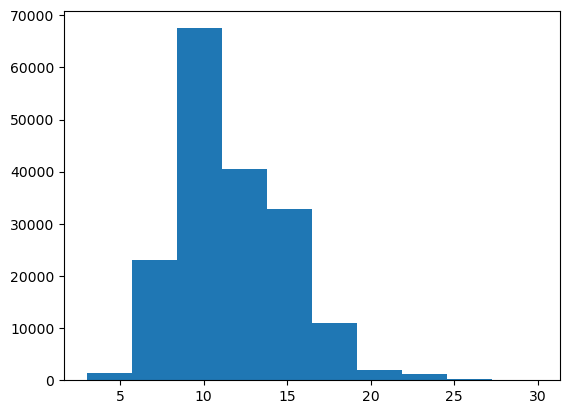

In [122]:
# Distribution of Total Lines:
plt.hist(train_df["Total_Lines"])
plt.show()

In [124]:
# Checking Coverage of Total Lines:
np.percentile(train_df["Total_Lines"], 98)

20.0

Plenty of converage. Let's one-hot-encode our `"total_lines"` column just as we did our `"line_number"` column.

In [125]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 

train_total_lines_one_hot = tf.one_hot(train_df["Total_Lines"].to_numpy(), depth= 20)
val_total_lines_one_hot = tf.one_hot(val_df["Total_Lines"].to_numpy(), depth= 20)
test_total_lines_one_hot = tf.one_hot(test_df["Total_Lines"].to_numpy(), depth= 20)

In [126]:
train_total_lines_one_hot.shape, val_total_lines_one_hot.shape, test_total_lines_one_hot.shape

(TensorShape([180040, 20]), TensorShape([30212, 20]), TensorShape([30135, 20]))

In [128]:
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

### Building a tribrid embedding model

It's time to build the biggest model we've built yet. One which incorporates token embeddings, character embeddings and our newly crafted positional embeddings.

We'll be venturing into uncovered territory but there will be nothing here you haven't practiced before.

More specifically we're going to go through the following steps:

1. Create a token-level model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification to reflect the paper)
3. Create a `"line_number"` model (takes in one-hot-encoded `"line_number"` tensor and passes it through a non-linear layer)
4. Create a `"total_lines"` model (takes in one-hot-encoded `"total_lines"` tensor and passes it through a non-linear layer)
5. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
6. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding 
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)


In [129]:
# 1. Token Inputs:
token_inputs= Input(shape= [], dtype= tf.string, name= "Token_Input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(token_inputs, token_outputs)

# 2. Character Inputs:
char_inputs = Input(shape= (1,), dtype= tf.string, name= "Char_Input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeddings)
char_model = Model(char_inputs, char_bi_lstm)

# 3. Line Number Inputs:
line_number_inputs = Input(shape= (15,), dtype= tf.float32, name= "Line_Number_Input")
x = Dense(32, activation= "relu")(line_number_inputs)
line_number_model = Model(line_number_inputs, x)

# 4. Total Lines Inputs:
total_lines_inputs = Input(shape= (20,), dtype= tf.float32, name= "Total_Line_Input")
y = Dense(32, activation= "relu")(total_lines_inputs)
total_lines_model = Model(total_lines_inputs, y)

# 5. Combining Token and Character Models:
combined_embeddings = Concatenate(name= "Char_Token_Hybrid_Embedding")([token_model.output,
                                                                       char_model.output])
z = Dense(256, activation= "relu")(combined_embeddings)
z = Dropout(0.5)(z)

# 6. Combine Positional Embeddings with Combined Token and Char Embeddings into a Tribrid Embedding:
tribrid_embeddings = Concatenate(name= "Char_Token_Positional_Embedding")([line_number_model.output,
                                                                          total_lines_model.output,
                                                                          z])

# 7. Creating Output Layer:
output_layer = Dense(num_classes, activation= "softmax", name= "Output_Layer")(tribrid_embeddings)

# 8. Put Together Model with all kind of Inputs:
model_5 = Model(inputs= [line_number_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input],
               outputs= output_layer)

In [130]:
# Summary of The Model:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Token_Input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 Char_Vectorizer (TextVecto  (None, 290)                  0         ['Char_Input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_Sentence_Encoder  (None, 512)                  2567978   ['Token_Input[0][0]']   

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of: 
* `[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:
* `[0.01, 0.01, 0.96, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.

Resource: For more on label smoothing, see the great blog post by PyImageSearch, [*Label smoothing with Keras, TensorFlow, and Deep Learning*](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).

In [131]:
# Compiling The Model:
model_5.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy(label_smoothing= 0.2), # add label smoothing (examples which are really confident get smoothed a little)
               metrics= ["accuracy"]) 

### Create tribrid embedding datasets and fit tribrid model



To keep our experiments swift, let's fit on 20,000 examples for 3 epochs.

This time our model requires four feature inputs:
1. Train line numbers one-hot tensor (`train_line_numbers_one_hot`)
2. Train total lines one-hot tensor (`train_total_lines_one_hot`)
3. Token-level sequences tensor (`train_sentences`)
4. Char-level sequences tensor (`train_chars`)

We can pass these as tuples to our `tf.data.Dataset.from_tensor_slices()` method to create appropriately shaped and batched `PrefetchedDataset`'s.

In [132]:
# Create training and validation datasets (all four kinds of inputs):

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                  train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation Dataset:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                  val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [134]:
train_char_token_pos_dataset,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [135]:
# Fitting The Model:
model_5_history = model_5.fit(train_char_token_pos_dataset,
                             validation_data= val_char_token_pos_dataset,
                             epochs= 3,
                             steps_per_epoch= int(0.1 * len(train_char_token_pos_dataset)),
                             validation_steps= int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 52s 79ms/step - loss: 1.0967 - accuracy: 0.7250 - val_loss: 0.9870 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 42s 75ms/step - loss: 0.9711 - accuracy: 0.8125 - val_loss: 0.9513 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 40s 71ms/step - loss: 0.9519 - accuracy: 0.8210 - val_loss: 0.9402 - val_accuracy: 0.8321


In [136]:
# Evaluating Model 5 on whole Validation Dataset:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.9393 - accuracy: 0.8319


[0.9393044710159302, 0.8319211006164551]

In [137]:
# Making Predictions Using Model 5:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 21s 21ms/step


array([[0.49833128, 0.11489724, 0.01141174, 0.35855952, 0.0168002 ],
       [0.52182704, 0.10321147, 0.03969891, 0.32527897, 0.00998361],
       [0.295172  , 0.10121684, 0.10842288, 0.41827133, 0.07691697],
       ...,
       [0.04040939, 0.10394308, 0.03972869, 0.03358337, 0.78233534],
       [0.03429846, 0.23982951, 0.0777881 , 0.02596402, 0.62211996],
       [0.22139533, 0.54238313, 0.10972624, 0.04544218, 0.08105318]],
      dtype=float32)

In [139]:
# Converting Model Predictions to Class Labels:
model_5_preds = tf.argmax(model_5_pred_probs, axis= 1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [140]:
# Calculating Results of Model 5:
model_5_results = calculate_results(y_true= val_labels_encoded,
                                   y_pred= model_5_preds)
model_5_results

{'accuracy': 83.19210909572355,
 'precision': 0.8310008546461691,
 'recall': 0.8319210909572355,
 'f1': 0.8310025843125823}

## Compare model results 

Now it's time to compare each model's performance against each other.

We'll also be able to compare our model's to the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper.

Since all of our model results are in dictionaries, let's combine them into a pandas DataFrame to visualize them.

In [142]:
all_model_results = pd.DataFrame({"Model_0_Baseline": baseline_results,
                                "Model_1_Custom_Token_Embeddings": model_1_results,
                                "Model_2_PreTrained_Token_Embeddings": model_2_results,
                                "MOdel_3_Custom_Char_Embeddings": model_3_results,
                                "Model_4_Hybrid_Char_Token_Embeddings": model_4_results,
                                "Model_5_Char_Token_Pos_Embeddings": model_5_results})

In [144]:
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
Model_0_Baseline,72.183238,0.718647,0.721832,0.698925
Model_1_Custom_Token_Embeddings,78.382762,0.779909,0.783828,0.780984
Model_2_PreTrained_Token_Embeddings,71.249835,0.712728,0.712498,0.709309
MOdel_3_Custom_Char_Embeddings,66.476897,0.658570,0.664769,0.655398
Model_4_Hybrid_Char_Token_Embeddings,73.086853,0.732653,0.730869,0.728901
Model_5_Char_Token_Pos_Embeddings,83.192109,0.831001,0.831921,0.831003


In [145]:
# Adjusting Accuracy to sam scale as Other Metrics:
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
Model_0_Baseline,0.721832,0.718647,0.721832,0.698925
Model_1_Custom_Token_Embeddings,0.783828,0.779909,0.783828,0.780984
Model_2_PreTrained_Token_Embeddings,0.712498,0.712728,0.712498,0.709309
MOdel_3_Custom_Char_Embeddings,0.664769,0.658570,0.664769,0.655398
Model_4_Hybrid_Char_Token_Embeddings,0.730869,0.732653,0.730869,0.728901
Model_5_Char_Token_Pos_Embeddings,0.831921,0.831001,0.831921,0.831003


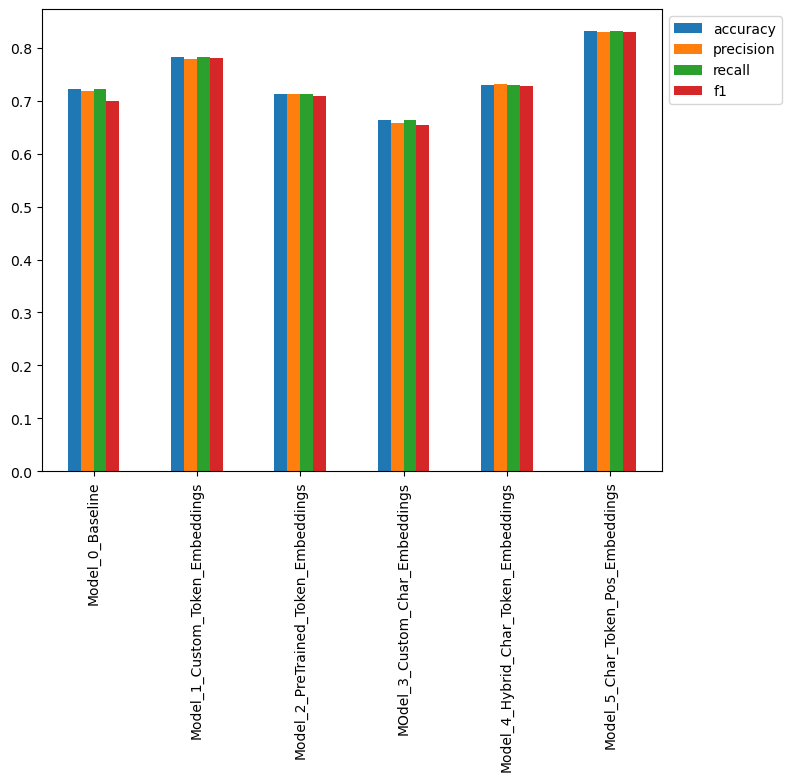

In [149]:
# Plotting Model Results:

all_model_results.plot(kind= "bar", figsize= (8,6)).legend(bbox_to_anchor= (1,1))
plt.show()

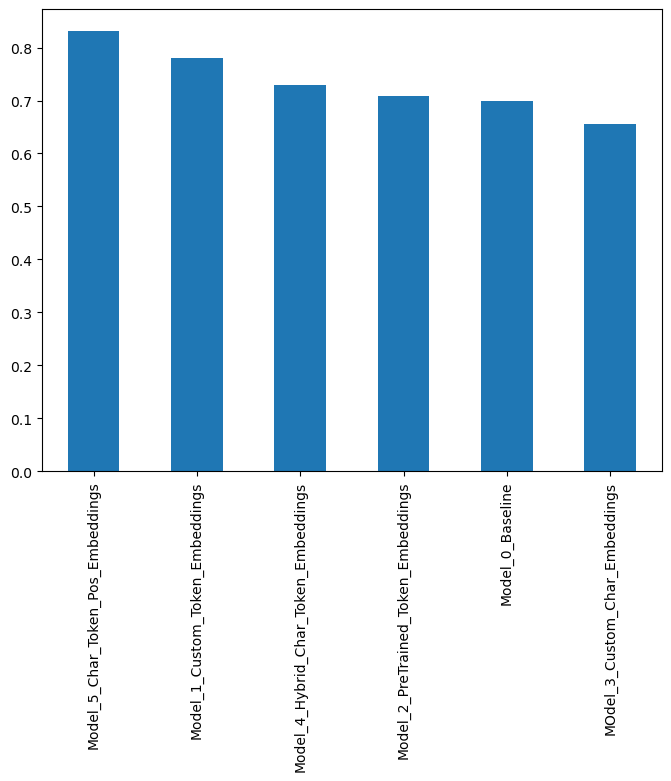

In [150]:
# Sorting aln Plotting Results by F1-Score:
all_model_results.sort_values("f1", ascending= False)["f1"].plot(kind= "bar", figsize=(8,6))
plt.show()

## Save and load best performing model

We can save our best performing model by calling the [`save()`](https://www.tensorflow.org/guide/keras/save_and_serialize#the_short_answer_to_saving_loading) method on it.

In [151]:
# Saving The Model (model_5):
model_5.save("Skimlit_20k_Model")

INFO:tensorflow:Assets written to: Skimlit_20k_Model\assets


INFO:tensorflow:Assets written to: Skimlit_20k_Model\assets


In [152]:
# Loading in Saved Model:
loaded_model = tf.keras.models.load_model("Skimlit_20k_Model")

In [153]:
# Making Predictions and Calculationg Results of Loaded Model:
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis= 1)
loaded_model_results = calculate_results(y_true= val_labels_encoded,
                                        y_pred = loaded_model_preds)
loaded_model_results

945/945 [==============================] - 21s 20ms/step


{'accuracy': 83.19210909572355,
 'precision': 0.8310008546461691,
 'recall': 0.8319210909572355,
 'f1': 0.8310025843125823}

In [154]:
model_5_results

{'accuracy': 83.19210909572355,
 'precision': 0.8310008546461691,
 'recall': 0.8319210909572355,
 'f1': 0.8310025843125823}

## Evaluate model on test dataset

To make our model's performance more comparable with the results reported in Table 3 of the [*PubMed 200k RCT:
a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/pdf/1710.06071.pdf) paper, let's make predictions on the test dataset and evaluate them.

In [155]:
# Create test dataset batch and prefetched

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                              test_total_lines_one_hot,
                                                              test_sentences,
                                                              test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_post_dataset = tf.data.Dataset.zip((test_char_token_pos_data,
                                                   test_char_token_pos_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [156]:
test_char_token_post_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [157]:
# Making Predictions on Test Data:
test_pred_probs = model_5.predict(test_char_token_post_dataset)

942/942 [==============================] - 20s 21ms/step


In [158]:
# Converting Model Probabilities into Class Labels:
test_preds = tf.argmax(test_pred_probs, axis= 1)
test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1], dtype=int64)>

In [159]:
# Calculating Results of Model on Test Data:
model_5_results_test_data = calculate_results(y_true= test_labels_encoded,
                                             y_pred= test_preds)
model_5_results_test_data

{'accuracy': 82.4622531939605,
 'precision': 0.8234996884816612,
 'recall': 0.8246225319396051,
 'f1': 0.8236841030165377}

## Find most wrong

One of the best ways to investigate where your model is going wrong (or potentially where your data is wrong) is to visualize the "most wrong" predictions.

The most wrong predictions are samples where the model has made a prediction with a high probability but has gotten it wrong (the model's prediction disagreess with the ground truth label).

Looking at the most wrong predictions can give us valuable information on how to improve further models or fix the labels in our data.

Let's write some code to help us visualize the most wrong predictions from the test dataset.

First we'll convert all of our integer-based test predictions into their string-based class names.

In [160]:
# Creating Label Names from Integer Label Classes:
test_pred_class = [label_encoder.classes_[item] for item in test_preds]
test_pred_class

['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 

In [162]:
# Create prediction-enriched test dataframe
test_df["Prediction"] = test_pred_class
test_df["Prediction Probability"] = tf.reduce_max(test_pred_probs, axis= 1).numpy()
test_df["Prediction State"] = test_df["Target"] == test_df["Prediction"]

In [163]:
test_df.head()

,Target,Text,Line_Number,Total_Lines,Prediction,Prediction Probability,Prediction State
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.447831,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.332845,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.794594,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652459,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.703375,True


In [164]:
# Wrong Predictions:
wrong_pred_df = test_df[test_df["Prediction State"] == False]
wrong_pred_df.head(10)

,Target,Text,Line_Number,Total_Lines,Prediction,Prediction Probability,Prediction State
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.447831,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.332845,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.794594,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.652459,False
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.473021,False
10,BACKGROUND,the aim of this study was to analyse the cost-...,1,12,OBJECTIVE,0.498572,False
20,RESULTS,nor was evar superior regarding cost-utility .,11,12,CONCLUSIONS,0.522210,False
23,METHODS,this study investigated whether oxytocin can a...,1,8,OBJECTIVE,0.589329,False
29,RESULTS,the biological mechanisms by which oxytocin ma...,7,8,CONCLUSIONS,0.663803,False
32,BACKGROUND,previous controlled exposure studies at a conc...,1,12,METHODS,0.622805,False


In [165]:
# Top 100 Most Wrong Predictions:
top_100_wrong = wrong_pred_df.sort_values("Prediction Probability", ascending= False)[:100]
top_100_wrong.head()

,Target,Text,Line_Number,Total_Lines,Prediction,Prediction Probability,Prediction State
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.949363,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.940714,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.935436,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.928115,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.915578,False


In [166]:
# Visualizing Most Wrong predictions:

for row in top_100_wrong[:10].itertuples():
    _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9493633508682251, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9407144784927368, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9354357719421387, Line number: 0, Total lines: 11

Text:
to assess the temporal patterns of late gastrointestinal ( gi ) and genitourinary ( gu ) radiotherapy toxicity and resolution rates in a randomised controlled trial ( all-ireland cooperative oncology research group @-@ ) assessing duration of neo-adjuvant ( na ) hormone therapy for localised prostate cancer .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9281145930290222, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: ME